In [ ]:
import stim
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import logging
from RareEventSimulator import RareEventSimulator

# Configuration / parameters
DISTANCE = 5
RNG_SEED = 42
np.random.default_rng(RNG_SEED)  # set RNG for reproducibility in numpy operations
SAMPLE_DIR = Path("./samples")
WEIGHTS_DIR = Path("./weights")
SAMPLE_DIR.mkdir(parents=True, exist_ok=True)
WEIGHTS_DIR.mkdir(parents=True, exist_ok=True)

# Circuit factory used by the simulator
circuit_p = lambda p: stim.Circuit.generated(
    "surface_code:rotated_memory_z",
    rounds=DISTANCE,
    distance=DISTANCE,
    after_clifford_depolarization=p,
    after_reset_flip_probability=p,
    before_measure_flip_probability=p,
    before_round_data_depolarization=p
)

# Instantiate simulator
simulator = RareEventSimulator(DISTANCE, circuit_p)

/Users/pablobonilla/.venvs/py3/lib/python3.11/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [2]:
# Helper utilities for the notebook
from pathlib import Path
import pickle
from typing import Dict, Tuple, Any
import numpy as np

def ensure_dirs(*paths: Path) -> None:
    for p in paths:
        Path(p).mkdir(parents=True, exist_ok=True)

def save_pickle(obj: Any, path: Path) -> None:
    ensure_dirs(path.parent)
    with open(path, "wb") as f:
        pickle.dump(obj, f)

def load_pickle(path: Path) -> Any:
    with open(path, "rb") as f:
        return pickle.load(f)

def aggregate_weight_counts(samples: Dict[Tuple[int, ...], int]) -> Tuple[np.ndarray, np.ndarray]:
    """Return (weights, counts) arrays aggregated from samples dict.
    Each sample key is a tuple of error indices; weight == len(key)."""
    weight_counts = {}
    for e, c in samples.items():
        w = len(e)
        weight_counts[w] = weight_counts.get(w, 0) + c
    weights = np.array(sorted(weight_counts.keys()))
    counts = np.array([weight_counts[w] for w in weights])
    return weights, counts

# Sample rare events using Metropolis 

In [3]:
# Small demo sampling
num_seed = 10
shots = 20000
burn_in = 1000
p = 1e-3
samples = simulator.sample(p=p, num_seed=num_seed, shots=shots, burn_in=burn_in, use_multiprocessing=False)
# Save a demo cache (optional)
save_pickle(samples, SAMPLE_DIR / f"{DISTANCE}_demo.pkl")
print(f"Collected {sum(samples.values())} sampled configurations across {len(samples)} unique error-sets.")

Collected 190000 sampled configurations across 184 unique error-sets.


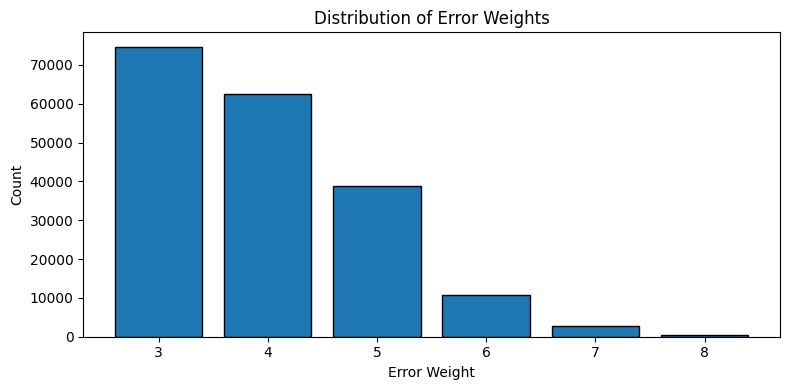

In [4]:
# Plot (bar plot of weight vs count)
weights, counts = aggregate_weight_counts(samples)
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(weights, counts, color='C0', edgecolor='black', width=0.8)
ax.set_xlabel('Error Weight')
ax.set_ylabel('Count')
ax.set_title('Distribution of Error Weights')
ax.set_xticks(weights)
plt.tight_layout()
plt.show()

# Calculate logical error rate at small physical error rate

In [5]:
p_target = 1e-3
p_known, LER_known = {5: (4e-3, 0.0076025), 7: (4e-3, 0.004296), 9: (4e-3, 0.002306)}[DISTANCE]
num_seed = 10
shots=int(1e6)
burn_in=50000
simulator.save_samples(p_target, p_known, num_seed, shots, burn_in, use_multiprocessing=True)
simulator.LER(p_target, p_known, LER_known, use_multiprocessing=False)

0.00014140294266860997